In [1]:
# Import Statements

#General Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

C:\Users\txcwa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Reading in kenpom data 
kenpom_raw_df = pd.read_csv('data/kenpom_raw.csv')

# Spliting Team to get tournament seed and dropping ranks for all other stats
kenpom_df = kenpom_raw_df.drop(['Rk', 'Unnamed: 6','Unnamed: 8','Unnamed: 10','Unnamed: 12','Unnamed: 14','Unnamed: 16'
                                ,'Unnamed: 18','Unnamed: 20'], axis = 1)

kenpom_df[['Team', 'Seed']] = kenpom_df['Team'].str.extract(r'^(.*?)(\d*)\*?$')
kenpom_df['Team'] = kenpom_df['Team'].str.rstrip()


In [3]:
# Creating Kenpom seed which is sorting on NetRtg (efficency on both sides of the ball) and giving every four teams the next numerical seed
# The first four teams get 1 the next four get 2, etc etc until the 64th team gets 16

def assign_kenpom_seed(df):
    # Sort by 'NetRtg' within each year and assign ranking
    df = df.sort_values(by='AdjEM', ascending=False).reset_index(drop=True)

    # Assign seeds 1 to 16 for top 64 teams, remaining get seed 99
    df['kenpom_seed'] = np.where(df.index < 64, (df.index // 4) + 1, 99)

    return df

# Group by 'year' and apply the seed assignment function
kenpom_df = kenpom_df.groupby('Year', group_keys=False).apply(assign_kenpom_seed)

#This works really well for the top end which is mostly what we care about but is a disaster at the lower end since
# a bunch of smaller schools make the tournament and take the 13 - 16 seeds. There are ways to fix this (Described below)
# but for the moment this is more than sufficient since this is not going to be used on the model. And is more of a comparison tool
# for the upper end on how the model does.

# This can fixed by including this for the top 50 teams then looking at teams in the tier 3 of conferences and randomizing the
# First few teams in each mid major conference a seed between 13-16. If these conferences have a team in the top 50 then we can
# assume they are the conference representatitve and ignore this process. 

In [5]:
# Not filled observations in Seed column are not recognized as nan so need to converted before the column can be filled and
# finally converted to dtype int
kenpom_df['Seed'] = kenpom_df['Seed'].replace('', np.nan)
kenpom_df['Seed'] = kenpom_df['Seed'].fillna(99)
kenpom_df['Seed'] = kenpom_df['Seed'].astype(int)

# Creating variable for see difference
kenpom_df['Seed_Difference'] = kenpom_df['Seed'].astype(int) - kenpom_df['kenpom_seed'].astype(int)
kenpom_df['Seed_Difference'] = kenpom_df['Seed_Difference'].astype(int)


In [6]:
# For some of the years in the dataframe range the NIT seed is contained in the Seed column (Only for seeds 1 - 8). The
# Function below are to work around these cases

def limit_seeds(df):
    # Sort the dataframe by Year and Seed
    df = df.sort_values(by=['Year', 'Seed'])
    
    # Define the special case limits for specific seeds
    # Play-in games can have up to 6 seeds for certain seeds (16, 10, 11, or 12) in some years
    special_seed_limits = {
        16: 6,  # Up to 6 teams allowed for seed 16
        10: 6,  # Only one of 10, 11, or 12 can have 6 teams, others have 4
        11: 6,  # We'll handle these dynamically based on data for each year
        12: 6
    }
    
    # Function to determine which of the 10, 11, 12 seeds have extra teams in a given year
    def handle_special_cases(df, year):
        if isinstance(year, (list, pd.Series, np.ndarray)):
            raise ValueError("The 'year' parameter should be a single integer or float value.")

        # Calculate counts for seeds 10, 11, and 12
        seed_counts = {
            10: df[(df['Year'].between(year - 0.5, year + 0.5)) & (df['Seed'] == 10)].shape[0],
            11: df[(df['Year'].between(year - 0.5, year + 0.5)) & (df['Seed'] == 11)].shape[0],
            12: df[(df['Year'].between(year - 0.5, year + 0.5)) & (df['Seed'] == 12)].shape[0]
        }

        # List comprehension to include all seeds with counts > 4
        extra_teams_seeds = [seed for seed, count in seed_counts.items() if count > 4]

        # Return list of seeds with extra teams, or None if none exceed 4
        return extra_teams_seeds if extra_teams_seeds else []

    # Group by Year and Seed, then count occurrences of each seed
    df['Seed_Count'] = df.groupby(['Year', 'Seed']).cumcount() + 1
    
    # Iterate through each year to apply limits
    for year in df['Year'].unique():
        
        # Handle seed 16 separately (always 6 teams in play-in cases)
        mask_16 = (df['Year'].between(year - 0.5, year + 0.5)) & (df['Seed'] == 16)
        df.loc[mask_16 & (df['Seed_Count'] > special_seed_limits[16]), 'Seed'] = 99
        
        # Determine which seed (10, 11, or 12) has the extra teams
        extra_seeds = handle_special_cases(df, year)
        
        # Apply the special limit for seeds with extra teams
        if extra_seeds is not None:
            for seed in extra_seeds:
                mask_extra = (df['Year'] == year) & (df['Seed'] == seed)
                df.loc[mask_extra & (df['Seed_Count'] > special_seed_limits[seed]), 'Seed'] = 99
        # Apply the default limit of 4 for other seeds
        for seed in range(1,16):
            if seed not in extra_seeds:

                mask_other = (df['Year'] == year) & (df['Seed'] == seed)
                df.loc[mask_other & (df['Seed_Count'] > 4), 'Seed'] = 99
    
    # Drop the helper Seed_Count column
    df.drop('Seed_Count', axis=1, inplace=True)
    
    return df




# Apply the function to your DataFrame
kenpom_df = limit_seeds(kenpom_df)

# Creating variable for see difference
kenpom_df['Seed_Difference'] = kenpom_df['Seed'].astype(int) - kenpom_df['kenpom_seed'].astype(int)
kenpom_df['Seed_Difference'] = kenpom_df['Seed_Difference'].astype(int)
kenpom_df

# Display the updated DataFrame
kenpom_snub_df = kenpom_df.sort_values(by = 'Seed_Difference', key = lambda x: x.abs(), ascending = False)
#kenpom_snub_df.head(20)
# kenpom_df

,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed,kenpom_seed,Seed_Difference
0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1,1,0
3,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1,1,0
6,Texas,B12,26-7,23.49,119.3,95.8,69.4,-0.009,10.36,107.1,96.7,2.16,2003,1,2,-1
8,Oklahoma,B12,27-7,23.01,112.1,89.1,62.7,0.034,9.01,106.7,97.7,-2.32,2003,1,3,-2
1,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Stonehill,NEC,4-27,-22.89,91.9,114.8,67.6,-0.078,-4.92,102.2,107.2,4.28,2024,99,99,0
358,Pacific,WCC,6-26,-22.91,95.2,118.2,68.2,-0.014,-0.04,106.3,106.3,-4.90,2024,99,99,0
359,IUPUI,Horz,6-26,-25.63,92.1,117.7,67.3,-0.019,-2.97,106.2,109.2,-4.18,2024,99,99,0
360,Coppin St.,MEAC,2-27,-25.86,85.6,111.5,66.0,-0.057,-5.13,102.8,107.9,0.72,2024,99,99,0


In [7]:
kenpom_misseed_df = kenpom_snub_df[kenpom_snub_df['Seed_Difference'].abs() < 20]
kenpom_misseed_df.head(25)

,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed,kenpom_seed,Seed_Difference
55,Vanderbilt,SEC,26-8,12.65,112.3,99.6,68.2,0.110,5.20,107.4,102.2,-1.70,2008,4,14,-10
63,Oregon St.,P12,19-13,11.65,110.7,99.1,67.1,0.043,9.61,109.8,100.2,0.46,2016,7,16,-9
47,Virginia,ACC,21-11,15.43,114.1,98.7,67.9,0.006,8.27,109.2,100.9,-4.35,2007,4,12,-8
58,Dayton,A10,25-8,12.63,106.6,94.0,67.8,0.082,3.89,107.3,103.4,2.58,2016,7,15,-8
56,Missouri,SEC,25-10,13.07,118.3,105.3,68.7,0.107,7.33,107.7,100.3,-5.09,2023,7,15,-8
57,DePaul,CUSA,22-10,11.36,113.0,101.6,63.2,0.091,5.83,106.4,100.6,-0.62,2004,7,15,-8
20,Utah St.,BW,24-8,19.62,116.0,96.4,61.1,-0.094,-2.48,101.3,103.8,-4.48,2005,14,6,8
9,Tennessee,SEC,24-13,23.69,117.9,94.2,61.6,-0.099,8.12,108.9,100.8,1.46,2014,11,3,8
7,Wichita St.,MVC,31-5,26.14,118.7,92.6,68.0,-0.021,1.50,105.0,103.5,-0.32,2017,10,2,8
59,Washington,P10,19-12,10.78,113.1,102.3,73.5,0.031,6.16,106.6,100.4,2.14,2004,8,15,-7


In [9]:
# From the above we can see that the Kenpom seeding is probably a more accurate reflection of a teams strength below are the
# outcomes of all the listed teams
# Vanderbilt 2008: Smoked in first round by 13 seed Siena
# Davidson 2008: Made Elite 8 and lost by 2 to eventual champion Kansas
# Oregon St. 2016: Lost to VCU in first game
# Dayton 2016: lost to Syracuse in first game
# Wichita St. 2016: Won play in and second round game bfore losiing in round of 32 to 3 seed Miami
# DePaul 2004 beat Dayton in first game and lost in second round to Uconn
# Washington 2004: Lost to UAB in first game
# Wichita St 2017 Lost to Kentucky (2 seed) in second game
# Missouri 2023: beat UT St. in first game but the lost to 15 seed Princeton in next game
# Utah St. 2005: Lost to Arizona (3 seed) in first game
# Charlotte 2005: Lost to NC State in first game
# Tennessee 2014: Made Sweet 16 but did not have to beat 3 seed Duke since the lost to Mercer in their first game
# UMass 2014: Played Tennessee (from above) in first round and lost
# Virginia 2007: Lost to Tennessee in second round 4 v 5 seed
# UCLA 2021: Lost to Gonzaga in Final Four
# Belmont 2012: Lost to Georgetown (3 seed) in first round
# Minnesota 2012: Not in Tourney?? 
# Richmond 2010: Lost in first game to Saint Mary's
# Wisconsin 2022: Lost to 11 seed Iowa St. in second game  
# South Carolina 2024: Lost to Oregon (11 Seed) in first game
# Belmont 2011: Lost to Wisconsin (4 seed) in first game
# Colorado 2016: Lost to Uconn in 8,9 mathcup
# Tennessee 2011: Smoked by Michigan in 8,9 matchup

In [10]:
#Prepping dataframe for Cluster algorithm

# Define conference tiers definition based on 2024 seeding results
conference_tiers = {
    'SEC': 1, 'B12': 1, 'B10': 1, 'ACC': 1, 'BE': 1, 'P12': 1, 'MWC': 1, 'P10':1,
    'A10': 2, 'AMER': 2, 'MVC': 2, 'WCC': 2
}

# Assign Tier 3 to the rest of the conferences
all_conferences = set(kenpom_df['Conf'].unique())
tier_three_conferences = all_conferences - set(conference_tiers.keys())
conference_tiers.update({conf: 3 for conf in tier_three_conferences})

# Create a function to map conferences to tiers
def map_tier(conf):
    return conference_tiers.get(conf, 3)  # Default to tier 3 if not found

# Apply conference tier mapping to Conf_A and Conf_B columns
kenpom_df['Conf_Tier'] = kenpom_df['Conf'].apply(map_tier)

# Create LabelEncoder object (for conferences)
label_encoder = LabelEncoder()

# Fit and transform Conf_A and Conf_B columns to integers
kenpom_df['Conf'] = label_encoder.fit_transform(kenpom_df['Conf'])

#Renaming a few columns
kenpom_df = kenpom_df.rename(columns = {'AdjEM':'NetRtg','AdjEM.1':'SOS_NetRtg','AdjEM.2':'NCSOS_NetRtg'})

# Split the W-L column into two columns: W and L
kenpom_df[['W', 'L']] = kenpom_df['W-L'].str.split('-', expand=True)

# Convert both columns to numeric
kenpom_df['W'] = pd.to_numeric(kenpom_df['W'])
kenpom_df['L'] = pd.to_numeric(kenpom_df['L'])

# kenpom_df

,Team,Conf,W-L,NetRtg,AdjO,AdjD,AdjT,Luck,SOS_NetRtg,OppO,OppD,NCSOS_NetRtg,Year,Seed,kenpom_seed,Seed_Difference,Conf_Tier,W,L
0,Kentucky,29,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1,1,0,1,32,4
3,Arizona,24,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1,1,0,1,28,4
6,Texas,6,26-7,23.49,119.3,95.8,69.4,-0.009,10.36,107.1,96.7,2.16,2003,1,2,-1,1,26,7
8,Oklahoma,6,27-7,23.01,112.1,89.1,62.7,0.034,9.01,106.7,97.7,-2.32,2003,1,3,-2,1,27,7
1,Kansas,6,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,2,1,1,1,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Stonehill,22,4-27,-22.89,91.9,114.8,67.6,-0.078,-4.92,102.2,107.2,4.28,2024,99,99,0,3,4,27
358,Pacific,34,6-26,-22.91,95.2,118.2,68.2,-0.014,-0.04,106.3,106.3,-4.90,2024,99,99,0,2,6,26
359,IUPUI,14,6-26,-25.63,92.1,117.7,67.3,-0.019,-2.97,106.2,109.2,-4.18,2024,99,99,0,3,6,26
360,Coppin St.,19,2-27,-25.86,85.6,111.5,66.0,-0.057,-5.13,102.8,107.9,0.72,2024,99,99,0,3,2,27


In [11]:
# Dropping non-tournament teams 
kenpom_tourney = kenpom_df[kenpom_df['Seed']<20]
kenpom_tourney = kenpom_tourney.sample(frac = 1).reset_index(drop = True)
# kenpom_tourney

,Team,Conf,W-L,NetRtg,AdjO,AdjD,AdjT,Luck,SOS_NetRtg,OppO,OppD,NCSOS_NetRtg,Year,Seed,kenpom_seed,Seed_Difference,Conf_Tier,W,L
0,Florida,29,29-8,31.18,117.2,86.0,61.9,-0.089,7.00,105.6,98.6,4.09,2013,3,1,2,1,29,8
1,Northern Kentucky,14,23-9,2.11,102.0,99.8,65.7,0.074,-5.16,100.0,105.2,-0.21,2020,15,99,-84,3,23,9
2,Marquette,7,26-9,18.32,113.2,94.9,63.3,0.090,9.28,105.9,96.6,-1.14,2013,3,7,-4,1,26,9
3,Memphis,4,24-10,15.22,112.4,97.1,67.5,0.048,7.25,108.3,101.1,0.02,2014,8,9,-1,3,24,10
4,Mississippi St.,29,23-11,16.77,108.2,91.5,66.6,-0.043,6.22,108.1,101.8,-1.48,2008,8,9,-1,1,23,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,Michigan,5,28-9,23.44,123.9,100.5,61.0,0.047,11.65,110.3,98.6,0.62,2014,2,3,-1,1,28,9
1458,Liberty,3,30-4,9.68,106.1,96.4,61.5,0.023,-9.00,98.3,107.3,-5.13,2020,12,99,-87,3,30,4
1459,Alabama,29,31-6,27.28,115.5,88.2,72.6,0.057,11.07,110.2,99.2,10.46,2023,1,1,0,1,31,6
1460,Tennessee,29,24-13,23.69,117.9,94.2,61.6,-0.099,8.12,108.9,100.8,1.46,2014,11,3,8,1,24,13


In [18]:
kenpom_knn_model_df = kenpom_tourney.drop(['W-L','kenpom_seed','Seed_Difference'], axis = 1)
kenpom_knn_model_df = kenpom_knn_model_df.set_index('Team')
kenpom_knn_model_2024 = kenpom_knn_model_df[kenpom_knn_model_df['Year'] == 2024]
# kenpom_knn_model_2024

,Conf,NetRtg,AdjO,AdjD,AdjT,Luck,SOS_NetRtg,OppO,OppD,NCSOS_NetRtg,Year,Seed,Conf_Tier,W,L
Team,,,,,,,,,,,,,,,
Baylor,6,22.30,122.5,100.2,65.6,-0.004,14.07,112.8,98.7,3.16,2024,3,1,23,10
Longwood,9,0.96,105.7,104.8,66.8,-0.047,-4.01,104.5,108.5,-6.74,2024,16,3,21,13
Colgate,26,2.15,104.7,102.5,66.2,0.057,-6.97,101.9,108.9,6.56,2024,14,3,25,9
Oakland,14,2.82,108.6,105.8,66.7,0.082,-1.08,107.1,108.2,9.90,2024,14,3,23,11
Arizona,25,26.62,121.1,94.5,71.8,-0.043,10.79,111.9,101.1,10.43,2024,2,1,25,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Grand Canyon,33,13.91,113.5,99.6,68.1,0.022,-1.42,104.1,105.6,-1.51,2024,12,3,29,4
Florida,29,18.19,119.3,101.1,71.7,-0.007,10.72,112.3,101.5,2.05,2024,7,1,24,11
Stetson,3,-4.10,110.3,114.4,66.2,0.137,-3.33,105.3,108.6,4.74,2024,16,3,22,12


In [13]:
kenpom_knn_model_df_fin = kenpom_knn_model_df[kenpom_knn_model_df['Year'] != 2024]


,Conf,NetRtg,AdjO,AdjD,AdjT,Luck,SOS_NetRtg,OppO,OppD,NCSOS_NetRtg,Year,Seed,Conf_Tier,W,L
Team,,,,,,,,,,,,,,,
Florida,29,31.18,117.2,86.0,61.9,-0.089,7.00,105.6,98.6,4.09,2013,3,1,29,8
Northern Kentucky,14,2.11,102.0,99.8,65.7,0.074,-5.16,100.0,105.2,-0.21,2020,15,3,23,9
Marquette,7,18.32,113.2,94.9,63.3,0.090,9.28,105.9,96.6,-1.14,2013,3,1,26,9
Memphis,4,15.22,112.4,97.1,67.5,0.048,7.25,108.3,101.1,0.02,2014,8,3,24,10
Mississippi St.,29,16.77,108.2,91.5,66.6,-0.043,6.22,108.1,101.8,-1.48,2008,8,1,23,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Michigan,5,23.44,123.9,100.5,61.0,0.047,11.65,110.3,98.6,0.62,2014,2,1,28,9
Liberty,3,9.68,106.1,96.4,61.5,0.023,-9.00,98.3,107.3,-5.13,2020,12,3,30,4
Alabama,29,27.28,115.5,88.2,72.6,0.057,11.07,110.2,99.2,10.46,2023,1,1,31,6


In [14]:
# Define your feature variables (X) and target variable (y)
X = kenpom_knn_model_df_fin.drop('Seed', axis = 1)  # Example features
y = kenpom_knn_model_df_fin['Seed'].astype(int)  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Set up the parameter grid for k
param_grid = {'n_neighbors': np.arange(1, 31)}

# Set up the KNN classifier
knn = KNeighborsClassifier()

# Perform grid search
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)

# Get the best K
best_k = knn_gscv.best_params_['n_neighbors']
print(f"Best value for k: {best_k}")

# Train the model with the best k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

Best value for k: 26


KNeighborsClassifier(n_neighbors=26)

Accuracy: 0.29
              precision    recall  f1-score   support

           1       0.77      0.62      0.69        16
           2       0.47      0.47      0.47        17
           3       0.20      0.23      0.21        13
           4       0.22      0.33      0.26        15
           5       0.17      0.38      0.23        13
           6       0.22      0.10      0.14        20
           7       0.18      0.12      0.14        17
           8       0.25      0.17      0.20        24
           9       0.12      0.21      0.15        14
          10       0.12      0.04      0.06        24
          11       0.09      0.12      0.11        16
          12       0.32      0.54      0.40        13
          13       0.38      0.27      0.32        22
          14       0.33      0.13      0.19        23
          15       0.39      0.47      0.42        15
          16       0.52      0.76      0.62        17

    accuracy                           0.29       279
   macro av

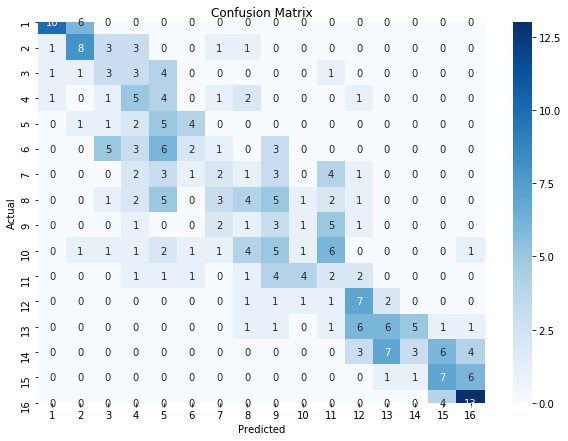

In [15]:
# Make predictions
y_pred = knn_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


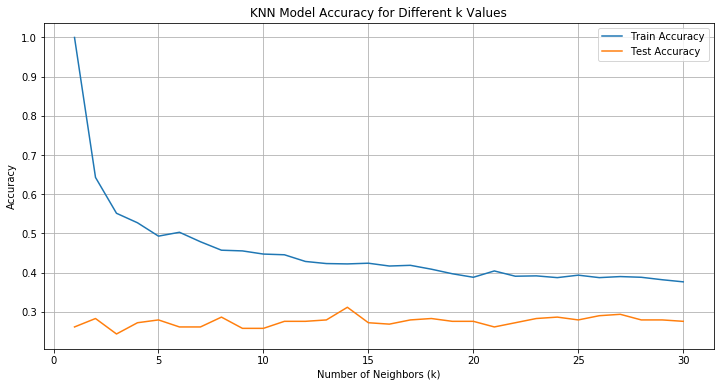

In [16]:
# Plot accuracy for different values of k
k_values = np.arange(1, 31)
train_scores = []
test_scores = []

for k in k_values:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    train_scores.append(knn_k.score(X_train, y_train))
    test_scores.append(knn_k.score(X_test, y_test))

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, label='Train Accuracy')
plt.plot(k_values, test_scores, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for Different k Values')
plt.legend()
plt.grid()
plt.show()
